In [3]:
#### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arc-prize-2025/arc-agi_training_solutions.json
/kaggle/input/arc-prize-2025/arc-agi_evaluation_solutions.json
/kaggle/input/arc-prize-2025/arc-agi_evaluation_challenges.json
/kaggle/input/arc-prize-2025/sample_submission.json
/kaggle/input/arc-prize-2025/arc-agi_training_challenges.json
/kaggle/input/arc-prize-2025/arc-agi_test_challenges.json
/kaggle/input/suyambhoo.v4.0.0019/pytorch/4.0.0019/1/best_model.4.0.0019chkpt


Using device: cuda
Loading ARC AGI data...
Loaded 120 training pairs and 120 test inputs.
Model parameters: 3,535,946
Checking for checkpoint at: /kaggle/input/suyambhoo.v4.0.0019/pytorch/4.0.0019/1/best_model.4.0.0019chkpt
✓ Found existing checkpoint from epoch 3499 with loss: 0.0019
✓ Checkpoint loaded from: /kaggle/input/suyambhoo.v4.0.0019/pytorch/4.0.0019/1/best_model.4.0.0019chkpt
Loading model from: /kaggle/input/suyambhoo.v4.0.0019/pytorch/4.0.0019/1/best_model.4.0.0019chkpt
✓ Loaded best model from epoch 3499 with loss: 0.0019
✓ Model loaded from: /kaggle/input/suyambhoo.v4.0.0019/pytorch/4.0.0019/1/best_model.4.0.0019chkpt
Resuming training from epoch 3500 with best loss: 0.0019
Training for 4000 epochs starting from epoch 3500...
Epoch [3510/4000], Loss: 0.0543
Epoch [3520/4000], Loss: 0.2852
Epoch [3530/4000], Loss: 0.2025
Epoch [3540/4000], Loss: 0.0724
Epoch [3550/4000], Loss: 0.0431
Epoch [3560/4000], Loss: 0.0528
Epoch [3570/4000], Loss: 0.0202
Epoch [3580/4000], Loss: 

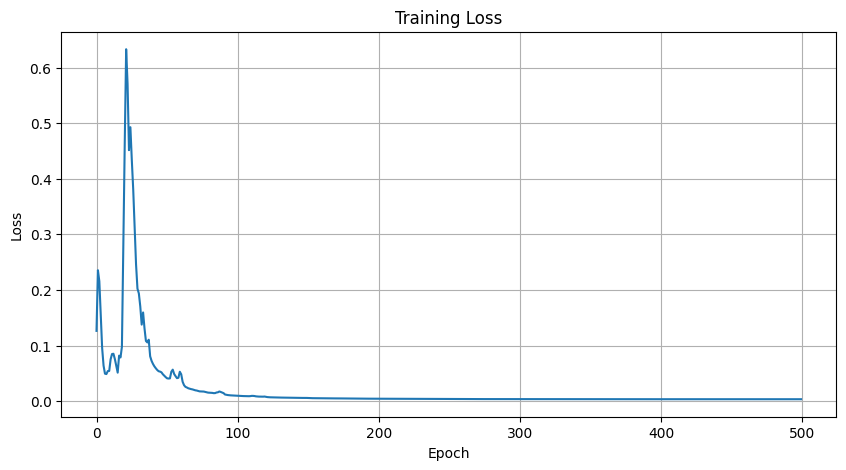

Loading best model for predictions...
Loading model from: /kaggle/working/best_model.chkpt
✓ Loaded best model from epoch 3499 with loss: 0.0019
✓ Model loaded from: /kaggle/working/best_model.chkpt
Generating predictions for test inputs...


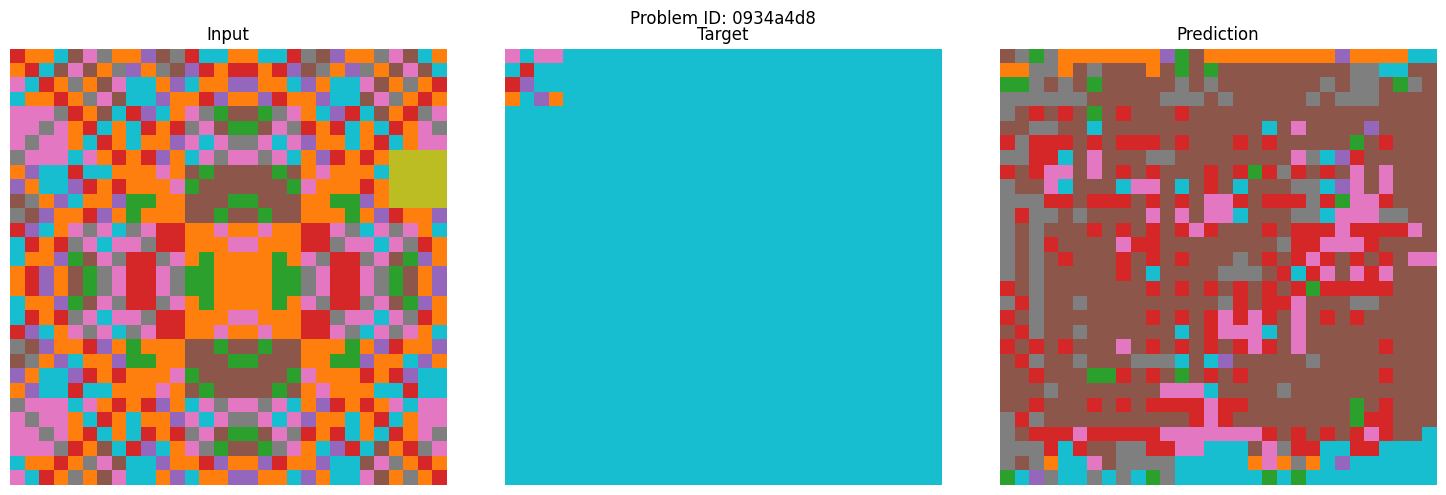

Predictions saved to arc_predictions.pt

Training completed!
Final loss: 0.0034
Generated predictions for 120 test problems


In [6]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from pprint import pprint

NUM_OF_EPOCHS = 4000

class ARCDataset(Dataset):
    """Dataset class for ARC AGI training data"""
    def __init__(self, training_pairs):
        self.data = []
        for problem_id, (input_tensor, output_tensor) in training_pairs.items():
            self.data.append((input_tensor, output_tensor))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

class ARCNeuralNetwork(nn.Module):
    """Deep neural network for ARC AGI tasks"""
    def __init__(self, input_channels=10, output_channels=10, hidden_dim=128):
        super(ARCNeuralNetwork, self).__init__()
        
        # Encoder: Process input grid
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 15x15
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        
        # Decoder: Generate output grid
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # 30x30
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, output_channels, kernel_size=3, padding=1),
        )
        
        # Attention mechanism for pattern recognition
        self.attention = nn.MultiheadAttention(embed_dim=512, num_heads=8, batch_first=True)
        
    def forward(self, x):
        # x shape: (batch_size, 30, 30, 10)
        # Convert to (batch_size, 10, 30, 30) for conv layers
        x = x.permute(0, 3, 1, 2)
        
        # Encode
        encoded = self.encoder(x)  # (batch_size, 512, 15, 15)
        
        # Apply attention
        batch_size, channels, height, width = encoded.shape
        encoded_flat = encoded.view(batch_size, channels, -1).permute(0, 2, 1)  # (batch_size, 225, 512)
        attended, _ = self.attention(encoded_flat, encoded_flat, encoded_flat)
        attended = attended.permute(0, 2, 1).view(batch_size, channels, height, width)
        
        # Decode
        decoded = self.decoder(attended)  # (batch_size, 10, 30, 30)
        
        # Convert back to (batch_size, 30, 30, 10)
        output = decoded.permute(0, 2, 3, 1)
        
        return output

def one_hot_2d_matrix(matrix, num_classes=10, max_size=30):
    """Convert a 2D matrix of values 0-9 to a 30x30x10 one-hot tensor."""
    h, w = len(matrix), len(matrix[0])
    arr = np.full((max_size, max_size), -1, dtype=np.int64)
    arr[:h, :w] = np.array(matrix)
    one_hot = np.eye(num_classes)[arr]  # shape: (30, 30, 10)
    return torch.tensor(one_hot, dtype=torch.float32)

def load_arc_data(json_path):
    """Load ARC AGI data from JSON file"""
    with open(json_path, 'r') as f:
        data = json.load(f)

    training_pairs = {}  # Dict of problem_id and corresponding (input_tensor, output_tensor)
    testing_inputs = {}  # Dict of problem_id and corresponding input_tensors

    first = True
    first_problem_id = None
    
    for problem_id, problem in data.items():
        # Train data
        for pair in problem['train']:
            if first:
                first_problem_id = problem_id
                # print("First Problem ID:", first_problem_id)
                # print("First Pair:")
                # pprint(pair)
            inp = one_hot_2d_matrix(pair['input'])
            out = one_hot_2d_matrix(pair['output'])
            if first:
                # print("First Input shape:", inp.shape)
                # print("First Output shape:", out.shape)
                first = False
            training_pairs[problem_id] = (inp, out)
        # Test data
        for test_case in problem['test']:
            inp = one_hot_2d_matrix(test_case['input'])
            testing_inputs[problem_id] = inp

    return first_problem_id, training_pairs, testing_inputs

def train_model(model, train_loader, num_epochs=100, device='cpu', start_epoch=0, best_loss=None):
    """Train the neural network"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    
    # Use provided best_loss or initialize to infinity
    if best_loss is None:
        best_loss = float('inf')
    
    # If starting from a previous epoch, the model should already be loaded
    if start_epoch > 0:
        print(f"Resuming training from epoch {start_epoch} with best loss: {best_loss:.4f}")
    else:
        print(f"Starting training from scratch")
    
    model.train()
    losses = []
    
    print(f"Training for {num_epochs} epochs starting from epoch {start_epoch}...")
    for epoch in range(start_epoch, num_epochs):
        epoch_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Reshape for loss calculation
            outputs_flat = outputs.reshape(-1, 10)  # (batch_size * 30 * 30, 10)
            targets_flat = torch.argmax(targets, dim=-1).reshape(-1)  # (batch_size * 30 * 30)
            
            loss = criterion(outputs_flat, targets_flat)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        scheduler.step()
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        
        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, 'best_model.chkpt')
            print(f'Epoch [{epoch+1}/{num_epochs}], New best loss: {avg_loss:.4f} - Model saved!')
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
    return losses

def check_existing_checkpoint(checkpoint_path):
    """Check if a checkpoint file exists and return the starting epoch"""
    import os
    print(f"Checking for checkpoint at: {checkpoint_path}")
    if os.path.exists(checkpoint_path):
        try:
            if torch.cuda.is_available():
                checkpoint = torch.load(checkpoint_path)
            else:
                checkpoint = torch.load(checkpoint_path, map_location='cpu')
            start_epoch = checkpoint['epoch'] + 1  # Start from next epoch
            print(f"✓ Found existing checkpoint from epoch {checkpoint['epoch']} with loss: {checkpoint['loss']:.4f}")
            print(f"✓ Checkpoint loaded from: {checkpoint_path}")
            return start_epoch
        except Exception as e:
            print(f"✗ Error loading checkpoint from {checkpoint_path}: {e}")
            print("Starting training from scratch.")
            return 0
    else:
        print(f"✗ No existing checkpoint found at {checkpoint_path}. Starting training from scratch.")
        return 0

def load_best_model(model, checkpoint_path, device='cpu'):
    """Load the best model from checkpoint"""
    print(f"Loading model from: {checkpoint_path}")
    try:
        if torch.cuda.is_available():
            checkpoint = torch.load(checkpoint_path)
        else:
            checkpoint = torch.load(checkpoint_path, map_location='cpu')
        
        model.load_state_dict(checkpoint['model_state_dict'])
        best_loss = checkpoint['loss']
        print(f"✓ Loaded best model from epoch {checkpoint['epoch']} with loss: {best_loss:.4f}")
        print(f"✓ Model loaded from: {checkpoint_path}")
        return model, best_loss
    except Exception as e:
        print(f"✗ Error loading model from {checkpoint_path}: {e}")
        print("Using randomly initialized model.")
        return model, None

def generate_predictions(model, test_inputs, device='cpu'):
    """Generate predictions for test inputs"""
    model.eval()
    predictions = {}
    
    with torch.no_grad():
        for problem_id, input_tensor in test_inputs.items():
            input_tensor = input_tensor.unsqueeze(0).to(device)  # Add batch dimension
            output = model(input_tensor)
            
            # Convert one-hot back to indices
            predicted_indices = torch.argmax(output, dim=-1).squeeze(0)  # (30, 30)
            predictions[problem_id] = predicted_indices.cpu().numpy()
    
    return predictions

def visualize_results(input_tensor, target_tensor, predicted_tensor, problem_id):
    """Visualize input, target, and prediction"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Convert one-hot to indices for visualization
    input_indices = torch.argmax(input_tensor, dim=-1).numpy()
    target_indices = torch.argmax(target_tensor, dim=-1).numpy()
    
    axes[0].imshow(input_indices, cmap='tab10', vmin=0, vmax=9)
    axes[0].set_title('Input')
    axes[0].axis('off')
    
    axes[1].imshow(target_indices, cmap='tab10', vmin=0, vmax=9)
    axes[1].set_title('Target')
    axes[1].axis('off')
    
    axes[2].imshow(predicted_tensor, cmap='tab10', vmin=0, vmax=9)
    axes[2].set_title('Prediction')
    axes[2].axis('off')
    
    plt.suptitle(f'Problem ID: {problem_id}')
    plt.tight_layout()
    plt.savefig(f'arc_results_{problem_id}.png', dpi=150, bbox_inches='tight')
    plt.show()

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load data
    print("Loading ARC AGI data...")
    first_problem_id, training_pairs, testing_inputs = load_arc_data('/kaggle/input/arc-prize-2025/arc-agi_evaluation_challenges.json')
    print(f"Loaded {len(training_pairs)} training pairs and {len(testing_inputs)} test inputs.")
    
    # Create dataset and dataloader
    dataset = ARCDataset(training_pairs)
    train_loader = DataLoader(dataset, batch_size=4, shuffle=True)
    
    # Initialize model
    model = ARCNeuralNetwork().to(device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Check for existing checkpoint from the specified path
    checkpoint_path = '/kaggle/input/suyambhoo.v4.0.0019/pytorch/4.0.0019/1/best_model.4.0.0019chkpt'
    start_epoch = check_existing_checkpoint(checkpoint_path)
    
    # Initialize best_loss
    best_loss = None
    
    # If checkpoint exists, load the model state and get the best loss
    if start_epoch > 0:
        model, best_loss = load_best_model(model, checkpoint_path, device=device)
    
    # Train model
    losses = train_model(model, train_loader, num_epochs=NUM_OF_EPOCHS, device=device, start_epoch=start_epoch, best_loss=best_loss)
    
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig('training_loss.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Load best model for predictions (use the local best model that was saved during training)
    print("Loading best model for predictions...")
    model, _ = load_best_model(model, '/kaggle/working/best_model.chkpt', device=device)
    
    # Generate predictions
    print("Generating predictions for test inputs...")
    predictions = generate_predictions(model, testing_inputs, device=device)
    
    # Visualize results for first problem
    if first_problem_id in training_pairs and first_problem_id in testing_inputs:
        input_tensor, target_tensor = training_pairs[first_problem_id]
        predicted_tensor = predictions[first_problem_id]
        visualize_results(input_tensor, target_tensor, predicted_tensor, first_problem_id)
    
    # Save predictions
    torch.save(predictions, 'arc_predictions.pt')
    print("Predictions saved to arc_predictions.pt")
    
    # Print some statistics
    print(f"\nTraining completed!")
    print(f"Final loss: {losses[-1]:.4f}")
    print(f"Generated predictions for {len(predictions)} test problems")

if __name__ == "__main__":
    main()